In [41]:
import pandas as pd
import numpy as np

What does the alert querry itself returns??

# Alert Criteria for Suspect Merchants

The following criteria are used to identify suspect merchants for generating an alert:

## 1. Transações de Risco
- O comerciante deve ter transações de risco com tipos específicos: `'velocity_check'`, `'location_not_allowed'`, `'cp_location'`, ou `'cnp_location'`.

## 2. Transações Internacionais
- As transações de risco devem ser internacionais (`t7.international IS TRUE`).

## 3. Métodos de Captura de Transação
- As transações válidas devem ter métodos de captura `'mpos'`, `'contactless'`, ou `'emv'`.

## 4. Validação do Cartão
- As transações devem ter um `card_token_id` não nulo.

## 5. Exclusão de Especificações Bancárias
- O nome do banco emissor (`issuer`) deve ser diferente de `'caixa economica federal'`.

## 6. Estado do Comerciante
- O estado do comerciante deve ser `'approved'`.

## 7. Período de Transação
- As transações devem ter ocorrido nos últimos 3 dias (`DATETIME(t.created_at) >= CURRENT_DATE() - 1`).

## 8. Recência da Conta
- O comerciante não deve ser um novo cliente, ou seja, a conta deve ter sido criada há mais de 90 dias (`creation > 90`).

## 9. Concentração de BIN Internacional
- O comerciante não deve ter uma alta concentração de transações com emissores internacionais. A condição é que a proporção de transações internacionais não seja maior que 50% do total de transações.

## 10. Contagem de Transações em Janelas de Tempo
Dependendo do tempo de criação da conta (`creation`) e se o comerciante é pessoa física (`is_PF`), a contagem de transações em janelas de tempo de 3, 10, 20 e 40 minutos deve atender aos seguintes critérios:
- **Para Pessoa Física (is_PF = TRUE)**:
  - Contagem de transações (int_3min, int_10min, int_20min, int_40min) dentro dos limites definidos para criação maior ou menor que 90 dias.
- **Para Pessoa Jurídica (is_PF = FALSE)**:
  - Contagem de transações dentro dos limites definidos para criação maior ou menor que 180 dias.

## 11. Exclusões Específicas
- O comerciante não deve estar nas listas de exceções específicas (`monitoring_not_to_analyse` e `inkman_score`).

Esses critérios são aplicados para identificar comportamentos suspeitos de fraude ou abuso nas transações, e os comerciantes que atendem a esses critérios são marcados com um alerta detalhado e categorizado como suspeito.


Frist I'll take a look at the alerts that are from *PJ* and were created in the *last 180 days.*
Then I'll make the same analysis for *PF* that were create in the last *180 days*.
Try to find patterns where the alert works well, and them "fix" the querry.


In [42]:
data_cnpj = pd.read_csv("data/cp_international_bin_cnpj.csv")
data_cpf = pd.read_csv("data/cp_international_bin_cpf.csv")
data = pd.read_csv("data/cp_international_alert.csv")

In [43]:
data_cnpj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   user_id                                     104 non-null    int64  
 1   status                                      104 non-null    object 
 2   status_reason                               25 non-null     object 
 3   status_1                                    104 non-null    object 
 4   active_days_since_aquisition_from_merchant  104 non-null    int64  
 5   approved_transactions_count_from_merchant   104 non-null    int64  
 6   approved_amount_sum_from_merchant           104 non-null    float64
 7   cbk_tpv_ratio                               8 non-null      float64
 8   total_billing_amount                        8 non-null      float64
 9   total_chargebacks                           8 non-null      float64
 10  paid_ratio    

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   merchant_id                                 408 non-null    int64  
 1   international_cid                           408 non-null    int64  
 2   domestic_cid                                408 non-null    int64  
 3   int_pct                                     408 non-null    float64
 4   approved_amount_sum_from_merchant           408 non-null    float64
 5   approved_transactions_count_from_merchant   408 non-null    int64  
 6   active_days_since_aquisition_from_merchant  408 non-null    int64  
 7   status                                      408 non-null    object 
 8   status_reason                               184 non-null    object 
 9   status_1                                    408 non-null    object 
 10  elo_frauds_rep

In [45]:
data_cnpj = data[data['document_type_']=='cnpj']
total_cnpj = data_cnpj['status'].count()
active_cnpj = data_cnpj[data_cnpj['status'] == 'active'].count()[0]
blocked_cnpj = data_cnpj[data_cnpj['status'] == 'blocked'].count()[0]








data_cpf = data[data['document_type_']=='cpf']
total_cpf = data_cpf['status'].count()
active_cpf = data_cpf[data_cpf['status'] == 'active'].count()[0]
blocked_cpf = data_cpf[data_cpf['status'] == 'blocked'].count()[0]

/tmp/ipykernel_52593/3313256171.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  active_cnpj = data_cnpj[data_cnpj['status'] == 'active'].count()[0]
/tmp/ipykernel_52593/3313256171.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  blocked_cnpj = data_cnpj[data_cnpj['status'] == 'blocked'].count()[0]
/tmp/ipykernel_52593/3313256171.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  active_cpf = data_cpf[data_cpf['status'] == '

In [46]:
TP_cnpj_block = blocked_cnpj/total_cnpj*100
TP_cpf_block = blocked_cpf/total_cpf*100

In [47]:
print(f"In the last 90 days, out of {total_cnpj} CNPJ that were flagged by the alert. {blocked_cnpj} are still blocked and {active_cnpj} are active. {TP_cnpj_block:.2f}% are TP blocked.",'\n')

print(f"In the last 90 days, out of {total_cpf} CPF that were flagged by the alert. {blocked_cpf} are still blocked and {active_cpf} are active. {TP_cpf_block:.2f}% are TP blocked.",'\n')



In the last 90 days, out of 94 CNPJ that were flagged by the alert. 20 are still blocked and 73 are active. 21.28% are TP blocked. 

In the last 90 days, out of 314 CPF that were flagged by the alert. 151 are still blocked and 161 are active. 48.09% are TP blocked. 



It's very important to increase CNPJ precision, and to understand how to increase even further precision on CPF.

What do I want to figure it out? 
1. What is a common pattern between the ones that were truly blocked?
2. Thresholds for minimum transaction amounts. For CPF/CNPJ.
3. What is the CID concentration of someone that is blocked?

In [48]:
import matplotlib.pyplot as plt


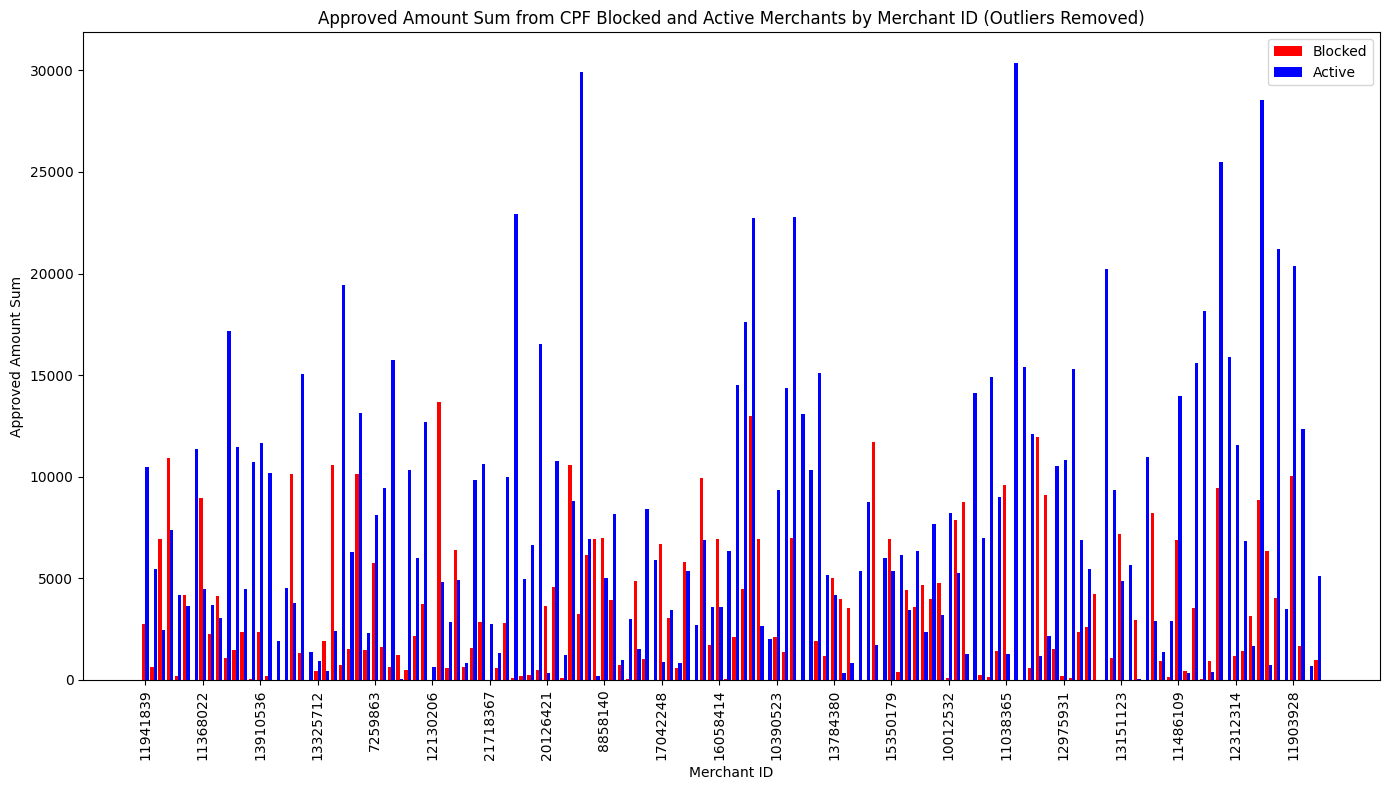

In [59]:

# Filtering data for blocked merchants
blocked_data_cpf = data_cpf[data_cpf['status'] == 'blocked']

# Removing outliers using the IQR method
Q1 = blocked_data_cpf['approved_amount_sum_from_merchant'].quantile(0.25)
Q3 = blocked_data_cpf['approved_amount_sum_from_merchant'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out the outliers
filtered_data_blocked = blocked_data_cpf[~((blocked_data_cpf['approved_amount_sum_from_merchant'] < (Q1 - 1.5 * IQR)) | (blocked_data_cpf['approved_amount_sum_from_merchant'] > (Q3 + 1.5 * IQR)))]

# Filtering data for active merchants
active_data_cpf = data_cpf[data_cpf['status'] == 'active']

# Removing outliers using the IQR method for active merchants
Q1_active = active_data_cpf['approved_amount_sum_from_merchant'].quantile(0.25)
Q3_active = active_data_cpf['approved_amount_sum_from_merchant'].quantile(0.75)
IQR_active = Q3_active - Q1_active

# Filtering out the outliers for active merchants
filtered_data_active = active_data_cpf[~((active_data_cpf['approved_amount_sum_from_merchant'] < (Q1_active - 1.5 * IQR_active)) | (active_data_cpf['approved_amount_sum_from_merchant'] > (Q3_active + 1.5 * IQR_active)))]

# Ensure the lengths are equal
min_length = min(len(filtered_data_blocked), len(filtered_data_active))
filtered_data_blocked = filtered_data_blocked.head(min_length)
filtered_data_active = filtered_data_active.head(min_length)

# Plotting a bar plot to visualize approved_amount_sum_from_merchant by merchant_id for filtered blocked and active merchants
fig, ax = plt.subplots(figsize=(14, 8))

positions_blocked = range(len(filtered_data_blocked))
positions_active = [pos + width for pos in positions_blocked]

ax.bar(positions_blocked, filtered_data_blocked['approved_amount_sum_from_merchant'], width=0.4, color='red', label='Blocked')
ax.bar(positions_active, filtered_data_active['approved_amount_sum_from_merchant'], width=0.4, color='blue', label='Active')

ax.set_xlabel('Merchant ID')
ax.set_ylabel('Approved Amount Sum')
ax.set_title('Approved Amount Sum from CPF Blocked and Active Merchants by Merchant ID (Outliers Removed)')

# Adjusting x-axis labels to show only a subset for better readability
step = max(1, len(filtered_data_blocked) // 20)
ax.set_xticks([pos + 0.4 / 2 for pos in range(0, len(filtered_data_blocked), step)])
ax.set_xticklabels(filtered_data_blocked['merchant_id'].astype(str)[::step], rotation=90)

ax.legend()
plt.tight_layout()
plt.show()


In [65]:

# Calculate average approved amount sum
average_approved_amount_blocked_cpf = blocked_data_cpf['approved_amount_sum_from_merchant'].mean()
average_approved_amount_active_cpf = data_cpf['approved_amount_sum_from_merchant'].mean()

# Calculate quartiles
quartiles_blocked_cpf = blocked_data_cpf['approved_amount_sum_from_merchant'].quantile([0.25, 0.5, 0.75])
quartiles_active_cpf = data_cpf['approved_amount_sum_from_merchant'].quantile([0.25, 0.5, 0.75])


# Print results
print(f"Average Approved Amount Sum Blocked: {average_approved_amount_blocked_cpf:.2f}, Average Approved Amount Sum Active: {average_approved_amount_active_cpf:.2f}")
print(f"Quartiles Blocked:\n{quartiles_blocked_cpf},\nQuartiles Active:\n{quartiles_active_cpf}")

Average Approved Amount Sum Blocked: 3604.33, Average Approved Amount Sum Active: 7619.07
Quartiles Blocked:
0.25     223.24
0.50    1739.78
0.75    5775.62
Name: approved_amount_sum_from_merchant, dtype: float64,
Quartiles Active:
0.25     1169.0025
0.50     4171.9450
0.75    10022.4250
Name: approved_amount_sum_from_merchant, dtype: float64


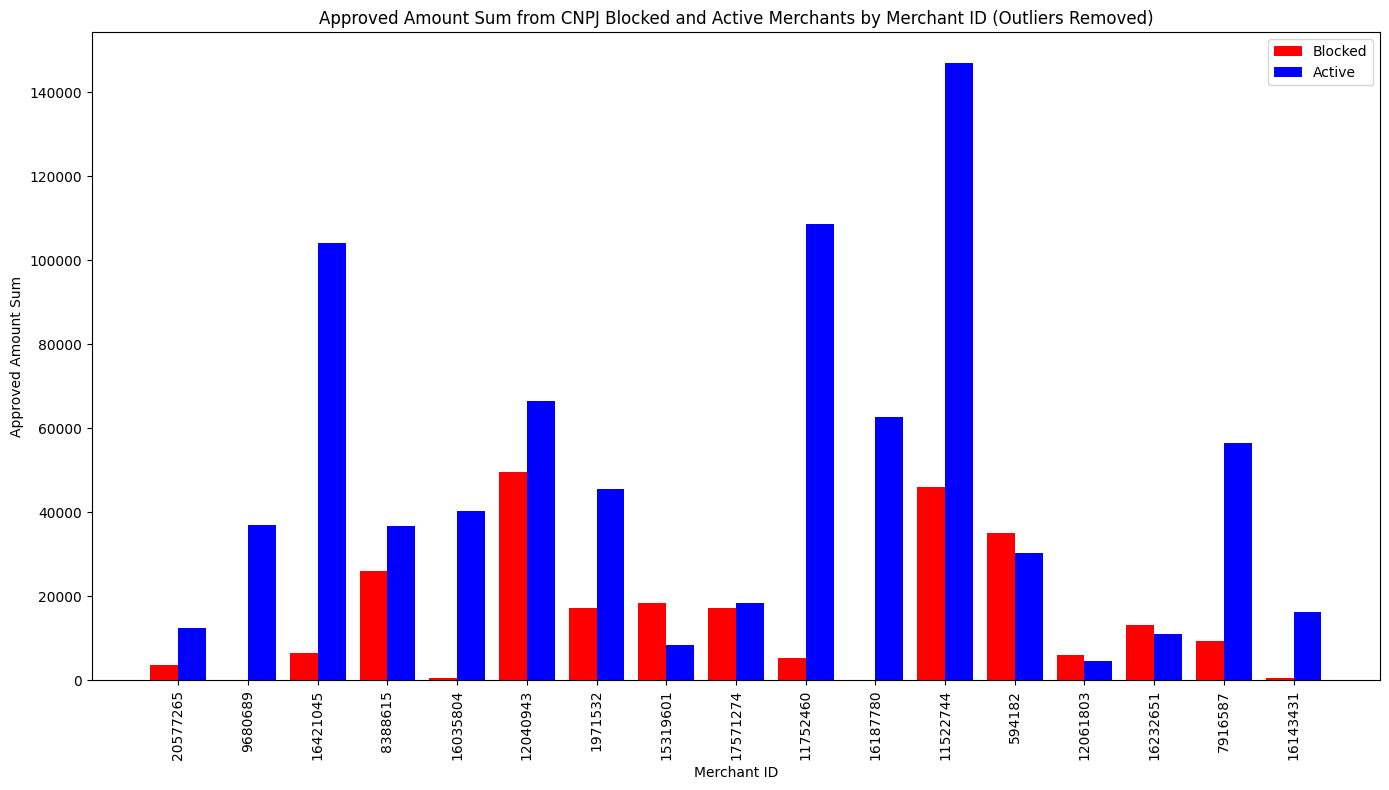

In [66]:


# Filtering data for blocked merchants
blocked_data_cnpj = data_cnpj[data_cnpj['status'] == 'blocked']

# Removing outliers using the IQR method
Q1 = blocked_data_cnpj['approved_amount_sum_from_merchant'].quantile(0.25)
Q3 = blocked_data_cnpj['approved_amount_sum_from_merchant'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out the outliers
filtered_data_blocked = blocked_data_cnpj[~((blocked_data_cnpj['approved_amount_sum_from_merchant'] < (Q1 - 1.5 * IQR)) | (blocked_data_cnpj['approved_amount_sum_from_merchant'] > (Q3 + 1.5 * IQR)))]

# Filtering data for active merchants
active_data_cnpj = data_cnpj[data_cnpj['status'] == 'active']

# Removing outliers using the IQR method for active merchants
Q1_active = active_data_cnpj['approved_amount_sum_from_merchant'].quantile(0.25)
Q3_active = active_data_cnpj['approved_amount_sum_from_merchant'].quantile(0.75)
IQR_active = Q3_active - Q1_active

# Filtering out the outliers for active merchants
filtered_data_active = active_data_cnpj[~((active_data_cnpj['approved_amount_sum_from_merchant'] < (Q1_active - 1.5 * IQR_active)) | (active_data_cnpj['approved_amount_sum_from_merchant'] > (Q3_active + 1.5 * IQR_active)))]

# Ensure the lengths are equal
min_length = min(len(filtered_data_blocked), len(filtered_data_active))
filtered_data_blocked = filtered_data_blocked.head(min_length)
filtered_data_active = filtered_data_active.head(min_length)

# Plotting a bar plot to visualize approved_amount_sum_from_merchant by merchant_id for filtered blocked and active merchants
fig, ax = plt.subplots(figsize=(14, 8))

positions_blocked = range(len(filtered_data_blocked))
positions_active = [pos + 0.4 for pos in positions_blocked]

ax.bar(positions_blocked, filtered_data_blocked['approved_amount_sum_from_merchant'], width=0.4, color='red', label='Blocked')
ax.bar(positions_active, filtered_data_active['approved_amount_sum_from_merchant'], width=0.4, color='blue', label='Active')

ax.set_xlabel('Merchant ID')
ax.set_ylabel('Approved Amount Sum')
ax.set_title('Approved Amount Sum from CNPJ Blocked and Active Merchants by Merchant ID (Outliers Removed)')

# Adjusting x-axis labels to show only a subset for better readability
step = max(1, len(filtered_data_blocked) // 20)
ax.set_xticks([pos + 0.4 / 2 for pos in range(0, len(filtered_data_blocked), step)])
ax.set_xticklabels(filtered_data_blocked['merchant_id'].astype(str)[::step], rotation=90)

ax.legend()
plt.tight_layout()
plt.show()


In [67]:
# Calculate average approved amount sum for CNPJ
average_approved_amount_blocked_cnpj = blocked_data_cnpj['approved_amount_sum_from_merchant'].mean()
average_approved_amount_active_cnpj = data_cnpj['approved_amount_sum_from_merchant'].mean()

# Calculate quartiles for CNPJ
quartiles_blocked_cnpj = blocked_data_cnpj['approved_amount_sum_from_merchant'].quantile([0.25, 0.5, 0.75])
quartiles_active_cnpj = data_cnpj['approved_amount_sum_from_merchant'].quantile([0.25, 0.5, 0.75])

# Print results
print(f"Average Approved Amount Sum Blocked: {average_approved_amount_blocked_cnpj:.2f}, Average Approved Amount Sum Active: {average_approved_amount_active_cnpj:.2f}")
print(f"Quartiles Blocked:\n{quartiles_blocked_cnpj},\nQuartiles Active:\n{quartiles_active_cnpj}")


Average Approved Amount Sum Blocked: 82445.42, Average Approved Amount Sum Active: 112838.36
Quartiles Blocked:
0.25     4795.7250
0.50    15101.9150
0.75    37782.7525
Name: approved_amount_sum_from_merchant, dtype: float64,
Quartiles Active:
0.25     16459.780
0.50     37565.285
0.75    112817.365
Name: approved_amount_sum_from_merchant, dtype: float64


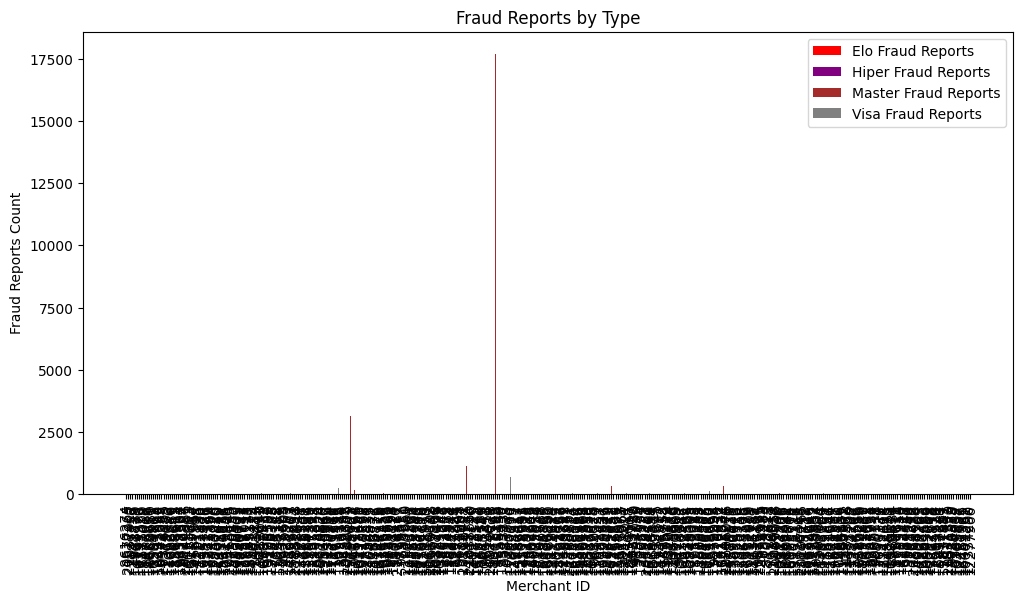

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(data['merchant_id']))

bar1 = ax.bar(index, data['elo_frauds_reports'], bar_width, label='Elo Fraud Reports', color='red')
bar2 = ax.bar([i + bar_width for i in index], data['hiper_frauds_reports'], bar_width, label='Hiper Fraud Reports', color='purple')
bar3 = ax.bar([i + 2 * bar_width for i in index], data['master_frauds_reports'], bar_width, label='Master Fraud Reports', color='brown')
bar4 = ax.bar([i + 3 * bar_width for i in index], data['visa_frauds_reports'], bar_width, label='Visa Fraud Reports', color='grey')

ax.set_xlabel('Merchant ID')
ax.set_ylabel('Fraud Reports Count')
ax.set_title('Fraud Reports by Type')
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(data['merchant_id'])
ax.legend()

plt.xticks(rotation=90)
plt.show()


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0      green
1        red
2      green
3      green
4        red
       ...  
403      red
404    green
405      red
406      red
407    green
Name: status, Length: 408, dtype: object

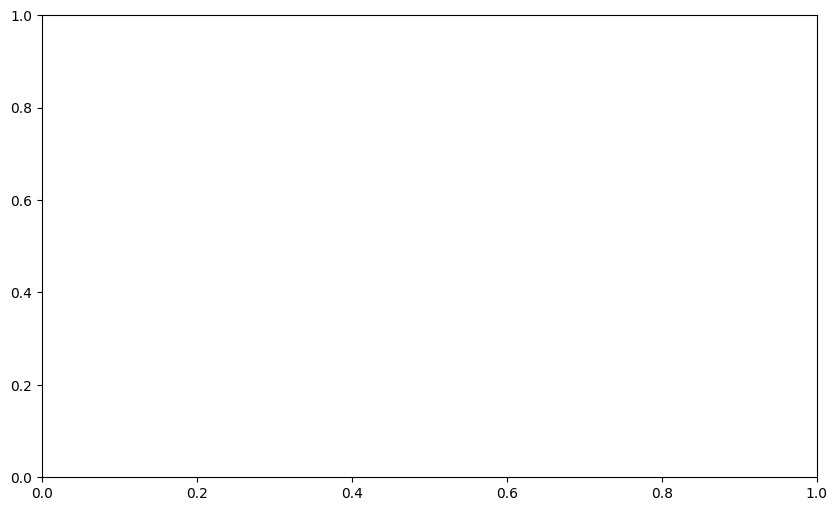

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'active': 'green', 'blocked': 'red'}
ax.scatter(data['international_cid'], data['domestic_cid'], c=data['status'].map(colors))
ax.set_xlabel('International CID')
ax.set_ylabel('Domestic CID')
ax.set_title('CID Concentration and Status')
plt.show()
